# Empirical Asset Pricing A 2021
## Homework 3&4: on empirical tests for conditional CAPM, return predictability
**Xinyu Liu, INSEAD**

**02.02.2021**

## Overview

The goal of this exercise is to get a sense of the testing procedures in conditional CAPM, and check predictability of the market return.

## Preparation: Import packages and access data


In [25]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
#pip install pandas-datareader (in case you haven't install this package)
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy as sp
from dateutil.relativedelta import relativedelta
import datapungibea as dpb
import os
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
# print latex 
# from IPython.display import display, Math

In [2]:
###########################
# Fama French Factor Grabber
###########################
#https://randlow.github.io/posts/finance-economics/pandas-datareader-KF/
#Please refer to this link if you have any further questions.

#You can extract all the available datasets from Ken French's website and find that there are 297 of them. We can opt to see all the datasets available.
datasets = get_available_datasets()
print('No. of datasets:{}'.format(len(datasets)))
#datasets # comment out if you want to see all the datasets

No. of datasets:297


In [195]:
###########################
#Customize your data selection
###########################
#It is important to check the description of the dataset we access by using the following codes 
sdate='1969-01-01'
edate='2018-12-31'
dir = os.path.realpath('.')

#### For $M kt-Rf, SMB, HML$ Factors:

In [196]:
Datatoread='F-F_Research_Data_Factors'
# Here are alternative dataset for predictability test
#  'F-F_Research_Data_Factors_weekly',
#  'F-F_Research_Data_Factors_daily',
ds_factors = web.DataReader(Datatoread,'famafrench',start=sdate,end=edate) # Taking [0] as extracting 1F-F-Research_Data_Factors_2x3')
print('\nKEYS\n{}'.format(ds_factors.keys()))
print('DATASET DESCRIPTION \n {}'.format(ds_factors['DESCR']))
#From the printed information we know that we need to select the "0" name in the dictionary
#copy the right dict for later examination
dfFactor = ds_factors[1].copy()
# 0 for monthly data and 1 for yearly data
dfFactor.reset_index(inplace=True)

#Date format adjustment
# dfFactor['Date']=dfFactor['Date'].dt.strftime('%Y-%m')
dfFactor = dfFactor.set_index(['Date'])
try:
    dfFactor.index=dfFactor.index.to_timestamp()
except Exception:
    pass
# dfFactor['Date']=dfFactor['Date'].dt.to_timestamp(freq='M').dt.strftime('%Y-%m')
#Obtained object dtype
# dfFactor.index=pd.to_datetime(dfFactor.index)
#Obtained dt64, which is needed for the plotting

RF = dfFactor['RF']
# dfFactor=dfFactor.drop(columns = ['RF'])
# I check the scale of the data by printing out the head:
dfFactor.head()


KEYS
dict_keys([0, 1, 'DESCR'])
DATASET DESCRIPTION 
 F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202012 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (600 rows x 4 cols)
  1 : Annual Factors: January-December (50 rows x 4 cols)


,Mkt-RF,SMB,HML,RF
Date,,,,
1969-01-01,-17.54,-13.97,-10.09,6.58
1970-01-01,-6.49,-11.81,21.49,6.52
1971-01-01,11.78,5.59,-11.19,4.39
1972-01-01,13.05,-11.90,1.49,3.84
1973-01-01,-26.19,-23.39,17.92,6.93


0 ACF
1 PACF


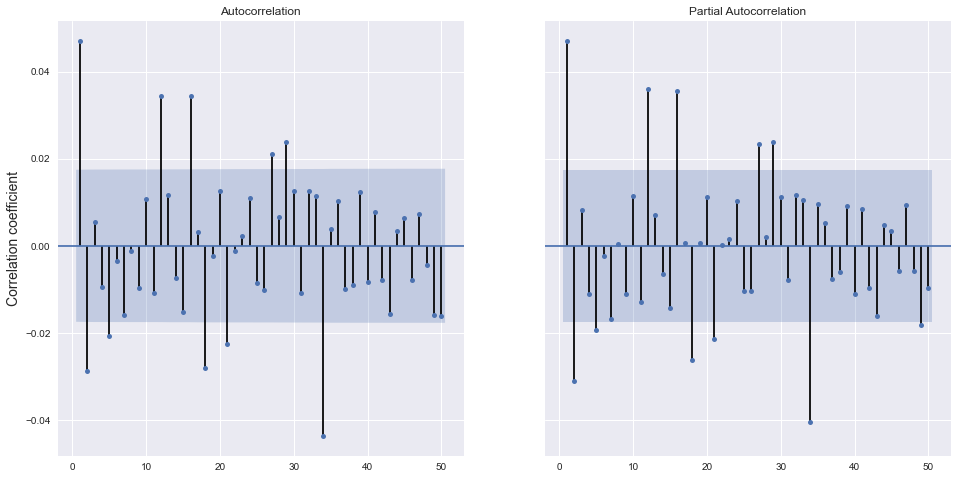

In [28]:
# Make the auto correlation plot 
series = dfFactor['Mkt-RF']
fig, axes = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)
colormap = plt.cm.get_cmap('twilight') 
colors = [colormap(i) for i in np.linspace(0.3, 0.5,5)]
# axes[0].plot([0.2, 1], [0.2, 1], ls="--", c=".3")
for i, k in enumerate(['ACF','PACF']):
    print(i,k)
    if i== 0:
        axes[i].set_ylabel('Correlation coefficient', fontsize = 14)
        plot_acf(series, lags=50,zero=False,ax= axes[i])
    else:
        plot_pacf(series, lags=50,zero=False,ax= axes[i])
#     axes[i].set_xlabel(k, fontsize = 14)
# plt.plot()
plt.savefig('ACF')
plt.show()

In [148]:
# Generate test dictionary
######
# Compbell 1997 table
######
def ACF_test(dftest, n_split=3):
    test = np.array_split(dftest, n_split)
    test.insert(0, dftest)
    test_result = {}
    for t,series in enumerate(test):
        start_date = series.index[0].date().strftime('%Y/%m/%d')
        end_date = series.index[-1].date().strftime('%Y/%m/%d')
        sample_range = start_date +'-'+end_date
        sample_num = len(series.index)
        sample_mean = np.round(series.mean(),3)
        sample_SD = np.round(series.std(),3)
        sample_coef = np.round(sm.tsa.acf(series,nlags=4)*100,1)
        sample_coef = sample_coef[1:]
        sample_LB5 = np.round(sm.stats.acorr_ljungbox(series, lags=[5])[0][0],1)
        sample_LB10 = np.round(sm.stats.acorr_ljungbox(series, lags=[10])[0][0],1)
        if t ==0:
            test_result['Sample Period'] = [sample_range]
            test_result['Sample Size'] = [sample_num]
            test_result['Mean'] = [sample_mean]
            test_result['SD'] = [sample_SD]
            for i in range(len(sample_coef)):
                test_result['\hat\rho_{}'.format(str(i+1))] = [sample_coef[i]]
            test_result['\hat Q_5'] =[sample_LB5]
            test_result['\hat Q_10'] =[sample_LB10]
        else:
            test_result['Sample Period'].append(sample_range)
            test_result['Sample Size'].append(sample_num)
            test_result['Mean'].append(sample_mean) 
            test_result['SD'].append(sample_SD) 
            for i in range(len(sample_coef)):
                test_result['\hat\rho_{}'.format(str(i+1))].append(sample_coef[i]) 
            test_result['\hat Q_5'].append(sample_LB5) 
            test_result['\hat Q_10'].append(sample_LB10)
    test_result=pd.DataFrame.from_dict(test_result)
    return test_result

In [149]:
out = ACF_test(dfFactor['Mkt-RF'])
print(out.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
         Sample Period &  Sample Size &   Mean &     SD &  \textbackslash hat\textbackslash rho\_1 &  \textbackslash hat\textbackslash rho\_2 &  \textbackslash hat\textbackslash rho\_3 &  \textbackslash hat\textbackslash rho\_4 &  \textbackslash hat Q\_5 &  \textbackslash hat Q\_10 \\
\midrule
 1969/01/01-2018/12/01 &          600 &  0.492 &  4.514 &         7.4 &        -3.1 &         1.8 &         1.7 &       5.9 &        9.4 \\
 1969/01/01-1985/08/01 &          200 &  0.148 &  4.744 &         6.6 &        -2.6 &         2.3 &         7.9 &       5.9 &        9.3 \\
 1985/09/01-2002/04/01 &          200 &  0.716 &  4.628 &         2.5 &        -8.0 &        -5.0 &       -10.4 &       4.2 &       10.3 \\
 2002/05/01-2018/12/01 &          200 &  0.613 &  4.151 &        13.0 &         0.0 &         8.1 &         8.6 &       6.3 &       14.2 \\
\bottomrule
\end{tabular}



In [194]:
######
# Cochrane 2005 table
######
def Cochrane_2005(dftest, horizons=[1,2,3,5,7,10]):
    dfreturn = pd.DataFrame(columns=['x','y'])
    ceof_dic= {'beta':[],'t':[],'ratio':[]}
    for h in horizons:
        dfreturn['x'] = dftest.rolling(h).sum()
        dfreturn['y'] = dftest.rolling(h).sum().shift(-h)
        dfreturn=dfreturn.dropna()
        X = sm.add_constant(dfreturn['x'])
        y = dfreturn['y']
        model = sm.OLS(y, X)
        results = model.fit()
        ceof_dic['beta'].append(np.round(results.params[1:][0],2))
        ceof_dic['t'].append(np.round(results.tvalues[1:][0],2))
        ceof_dic['ratio'].append(np.round(dfreturn['x'].std()/np.sqrt(h),1))
    ceof_dic = pd.DataFrame.from_dict(ceof_dic).T
    ceof_dic.columns = horizons
    return ceof_dic

In [197]:
ceof_dic = Cochrane_2005(dfFactor['Mkt-RF'])
print(ceof_dic.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &     1  &     2  &     3  &     5  &     7  &     10 \\
\midrule
beta  &  -0.03 &  -0.27 &  -0.14 &  -0.23 &  -0.26 &  -0.54 \\
t     &  -0.20 &  -1.88 &  -0.97 &  -1.67 &  -1.70 &  -3.81 \\
ratio &  18.00 &  17.90 &  16.20 &  15.50 &  13.00 &  12.70 \\
\bottomrule
\end{tabular}



In [198]:
ceof_dic = Cochrane_2005((np.log(dfFactor['Mkt-RF']/100+1)-1)*100)
print(ceof_dic.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &     1  &     2  &     3  &     5  &     7  &     10 \\
\midrule
beta  &  -0.01 &  -0.23 &  -0.14 &  -0.20 &  -0.20 &  -0.52 \\
t     &  -0.04 &  -1.64 &  -0.91 &  -1.49 &  -1.39 &  -3.66 \\
ratio &  18.50 &  18.50 &  17.00 &  16.30 &  13.90 &  13.60 \\
\bottomrule
\end{tabular}



#### For 25 portfolios formed on size and book-to-market (5 x 5)

In [16]:
# I searched for the exact name for this portfolio set by methods mentioned above
#It is important to check the description of the dataset we access by using the following codes 
Datatoread_PORT='25_Portfolios_5x5'
Datatoread_PORT='25_Portfolios_ME_BETA_5x5'
ds_PORT = web.DataReader(Datatoread_PORT,'famafrench',start=sdate,end=edate) # Taking [0] as extracting 1F-F-Research_Data_Factors_2x3')
print('\nKEYS\n{}'.format(ds_PORT.keys()))
print('DATASET DESCRIPTION \n {}'.format(ds_PORT['DESCR']))
#From the printed information we know that we need to select the "0" name in the dictionary
#copy the right dict for later examination
dfPORT = ds_PORT[0].copy()
dfPORT.reset_index(inplace=True)

dfPORT = dfPORT.set_index(['Date'])
# I check the scale of the data by printing out the head:
dfPORT.head()


KEYS
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'DESCR'])
DATASET DESCRIPTION 
 25 Portfolios ME BETA 5x5
-------------------------

This file was created by CMPT_ME_BEME_BETA_RETS using the 202012 CRSP database. It contains value- and equal-weighted returns for portfolios formed on ME, BEME, and BETA. The portfolios are constructed at the end of June. BEME is book value at the last fiscal year end of the prior calendar year divided by ME at the end of December of the prior year. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2020 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (600 rows x 25 cols)
  1 : Average Equal Weighted 

,SMALL LoBETA,ME1 BETA2,ME1 BETA3,ME1 BETA4,SMALL HiBETA,ME2 BETA1,ME2 BETA2,ME2 BETA3,ME2 BETA4,ME2 BETA5,...,ME4 BETA1,ME4 BETA2,ME4 BETA3,ME4 BETA4,ME4 BETA5,BIG LoBETA,ME5 BETA2,ME5 BETA3,ME5 BETA4,BIG HiBETA
Date,,,,,,,,,,,,,,,,,,,,,
1969-01,0.7114,-0.5067,-0.4396,-2.2617,-0.4236,0.9477,-1.9162,0.3303,-1.3263,0.3373,...,1.1357,-1.4246,-0.8019,-1.3928,0.6008,0.3861,-2.1246,-0.4754,-2.1974,-1.0246
1969-02,-7.8056,-7.4159,-9.5747,-8.5535,-12.4514,-4.7833,-7.7755,-7.7608,-7.2753,-10.8557,...,-6.7100,-5.9318,-6.1844,-7.7144,-10.6383,-4.2922,-2.9199,-3.5025,-5.9786,-9.7380
1969-03,2.7877,1.2355,3.7827,2.7572,4.0044,-1.0079,0.9839,2.4534,2.0779,2.7045,...,-0.5666,1.9329,3.1500,3.0133,2.2467,3.2743,4.4712,3.8806,0.2176,3.4849
1969-04,-0.7809,-0.4798,0.6686,-1.6919,1.9011,-1.1036,1.4231,1.3708,1.1678,2.3832,...,0.7118,1.3303,2.5057,-0.7987,2.6207,2.0249,3.7948,1.6835,0.6632,4.9693
1969-05,2.8118,2.0586,2.2356,-0.9005,1.1548,-1.0950,1.6183,-1.1206,-0.8521,0.6527,...,0.1234,-0.1173,2.3720,-0.4608,-2.9058,1.6468,-1.2799,0.9521,-1.0114,-0.4901


#### For monthly time-series of the default spread (”Baa - Aaa”)

In [53]:
# from fredapi import Fred
# fred = Fred(api_key='867c31a2baca3a69effa928b9b294289')
# Aaa = fred.get_series_latest_release('AAA')
# Baa = fred.get_series_latest_release('BAA')
####
# The API above is not stable so I make a local copy and access them below
####
filename = os.path.join(dir, 'Data','AAA.csv')
Aaa = pd.read_csv(filename,index_col='DATE',parse_dates=True)
filename = os.path.join(dir, 'Data','BAA.csv')
Baa = pd.read_csv(filename,index_col='DATE',parse_dates=True)

Bond_spread = pd.DataFrame({'Aaa':Aaa.iloc[:,0].values,'Baa':Baa.iloc[:,0].values},index = Aaa.index)
Bond_spread = Bond_spread[(Bond_spread.index<=pd.to_datetime(edate)) & (Bond_spread.index>=pd.to_datetime(sdate))]
Bond_spread['Spread'] = Bond_spread['Baa']- Bond_spread['Aaa']
dfFactor = dfFactor.merge(Bond_spread[['Spread']], how='inner', left_index=True, right_index=True)

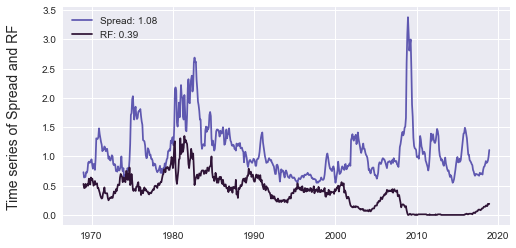

In [56]:
def portfolio_plot(df, num_subplot, plot_name='testing' ,figsize=(8,8), cmap ='twilight'):
    n = num_subplot
    fig, axes = plt.subplots(n,1,figsize=figsize,sharex=True,sharey=True)
    years_fmt = mdates.DateFormatter('%Y')
    # fig.suptitle('Time series of relevant variables',fontsize=16)
    # Add an origin point at the top of the dataframe
    dfcopy = df.copy()
#     dfcopy.index = dfcopy.index.to_timestamp()
#     origin = dfcopy.index[0]-relativedelta(months=1)
#     dfcopy.loc[origin,:] = [1]*len(dfcopy.columns)
#     dfcopy=dfcopy.sort_index()

    dfFactor_cum = dfcopy
    for k,factortitle in enumerate(dfcopy.columns):
        if n==1:
            ax = axes
        else:
            ax = axes[k//n]
        ax.plot(dfFactor_cum.index,dfFactor_cum[factortitle], label='{}: {:.2f}'.format(factortitle, dfFactor_cum[factortitle].mean()))
        ax.xaxis.set_major_formatter(years_fmt)
        colormap = plt.cm.get_cmap(cmap)   
        colors = [colormap(i) for i in np.linspace(0.3, 0.5,len(ax.lines))]
        for i,j in enumerate(ax.lines):
            j.set_color(colors[i])
        ax.legend(fontsize = 10,loc=2)
    fig.text(0.04, 0.5, 'Time series of ' +plot_name, va='center', ha='center',rotation='vertical',fontsize = 14)
    plt.savefig("Time series of "+plot_name)
    plt.show()
portfolio_plot(dfFactor[['Spread', 'RF']], 1, plot_name='Spread and RF' ,figsize=(8,4), cmap ='twilight')

#### For monthly time-series of labor income growth (BEA)

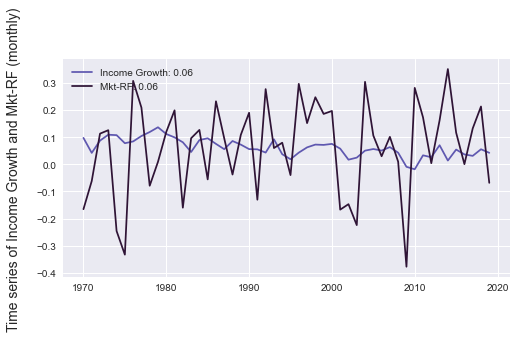

In [57]:
BEA_data = dpb.data('FDA2D756-CC0A-4AAA-A1D5-980FA23F31BB') #or data = dpb.data("API Key")
NIPA_cons=BEA_data.NIPA('T20600',frequency='M')
#Download annual consumption data on nondurable goods from Table 2.6. 
#on “Personal Income and Its Disposition, Monthly”
NIPA_cons.reset_index(inplace=True)
Compensation_data=NIPA_cons[NIPA_cons['LineDescription']=='-Compensation of employees']
Compensation_data = Compensation_data.T.iloc[4:,:]
Compensation_data.columns=['Compensation']
Compensation_data.index = pd.to_datetime(Compensation_data.index.values, format='%YM%m')
Compensation_data['Income Growth'] = (Compensation_data['Compensation']-Compensation_data['Compensation'].shift(1))/Compensation_data['Compensation'].shift(1)
# Convert strings to datetime 
Compensation_data = Compensation_data[(Compensation_data.index<=pd.to_datetime(edate)) & (Compensation_data.index>=pd.to_datetime(sdate))]
Compensation_data['Mkt-RF'] = dfFactor['Mkt-RF']/100
Compensation_data['Income Growth'] = Compensation_data['Income Growth']
labor_market = (Compensation_data[['Income Growth','Mkt-RF']]+1).astype('f').resample('Y').prod()-1
portfolio_plot(labor_market, 1, plot_name='Income Growth and Mkt-RF (monthly)' ,figsize=(8,4), cmap ='twilight')
dfFactor['Labor'] = Compensation_data['Income Growth'].astype('f')*100
# I don't know why but the api is not stable so I kept a copy of data 
# Compensation_data.to_pickle('compensation')
#or [All just for saving the intermediary data]
# Compensation_data.to_csv(os.path.join(dir, 'Data','Compensation.csv'))
# Compensation_data = pd.read_pickle('compensation')
# dfFactor.to_csv(os.path.join(dir, 'Data','dfFactor.csv'))

## Test functions 
#### Define the function for conducting cross-sectional test, where the first stage is a time series regression

In [10]:
# I can import directly the saved dfFactor
filename = os.path.join(dir, 'Data','dfFactor.csv')
dfFactor = pd.read_csv(filename,index_col='Date',parse_dates=True)

In [17]:
def FamaMacbeth_Test(factor_matrix, test_assets, RF):
    try:
        test_assets.index = test_assets.index.to_timestamp()
    except Exception:
        pass
    # Step one, time series regression, obtain estimated beta for each portfolio
    X = sm.add_constant(factor_matrix)
    beta_matrix = pd.DataFrame()
    for i in range(len(test_assets.columns)):
        y= test_assets.iloc[:,i]-RF
        model = sm.OLS(y, X)
        results = model.fit()
        beta_i = pd.DataFrame(results.params[1:]).T
        beta_matrix= pd.concat([beta_matrix, beta_i])
    beta_matrix.index = test_assets.columns

    # Step two, cross sectional regression, obtain estimated intercept and factor risk premium period by period
    X = sm.add_constant(beta_matrix)
    premium_matrix = pd.DataFrame()
    rsquare_matrix = []
    for i in range(len(test_assets.index)):
        # Note to be consisitent we should still use the excess return
        y= test_assets.iloc[i,:]-RF[i]
        model = sm.OLS(y, X)
        results = model.fit()
        premium_i = pd.DataFrame(results.params).T
        premium_matrix= pd.concat([premium_matrix, premium_i])
        
        rsquare_matrix.append(results.rsquared_adj)
    premium_matrix.index = factor_matrix.index
    
    ## Key formula to calculate the statistics
    point_estimate = premium_matrix.mean()
    N = len(test_assets.index)
    std = premium_matrix.std()/np.sqrt(N)
    df = N-1
    significant_level = 0.975
    critical_value = sp.stats.t.ppf(significant_level, df)
    CI = [point_estimate-std*critical_value, point_estimate+std*critical_value]
    reports = pd.DataFrame(point_estimate).T
    reports = reports.rename(index={0:'FM coef'})
    reports.loc['t-stats',:]= reports.iloc[0,:]/std

    print(reports.round(2).to_latex())
    return beta_matrix, premium_matrix, point_estimate, rsquare_matrix

In [18]:
beta_matrix, premium_matrix, point_estimate, rsquare_mean = FamaMacbeth_Test(dfFactor[['Mkt-RF', 'Spread','Labor']], dfPORT, RF)

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


\begin{tabular}{lrrrr}
\toprule
{} &  const &  Mkt-RF &  Spread &  Labor \\
\midrule
FM coef &   0.77 &   -0.22 &    0.35 &   0.09 \\
t-stats &   4.53 &   -0.89 &    2.48 &   0.45 \\
\bottomrule
\end{tabular}



In [73]:
beta_matrix, premium_matrix, point_estimate, rsquare_mean = FamaMacbeth_Test(dfFactor[['Mkt-RF']], dfPORT, RF)

\begin{tabular}{lrr}
\toprule
{} &  const &  Mkt-RF \\
\midrule
FM coef &   1.30 &   -0.62 \\
t-stats &   3.26 &   -1.43 \\
\bottomrule
\end{tabular}



In [286]:
# Sensitivity check for the parameters
cut = 240
beta_matrix, premium_matrix, point_estimate, rsquare_mean = FamaMacbeth_Test(dfFactor[['Mkt-RF', 'Spread','Labor']].iloc[:cut,:], dfPORT.iloc[:cut,:], RF[:cut])

\begin{tabular}{lrrrr}
\toprule
{} &  const &  Mkt-RF &  Spread &  Labor \\
\midrule
FM coef &   1.23 &   -0.86 &    0.31 &  -0.02 \\
t-stats &   2.55 &   -1.51 &    2.49 &  -0.21 \\
\bottomrule
\end{tabular}



In [21]:
# Rolling average calcualtion for list data
numbers = rsquare_mean
window_size = 120
numbers_series = pd.Series(numbers)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


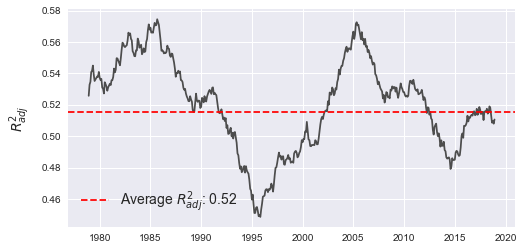

In [22]:
# plot time series of rolling average
fig, axes = plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
fig.text(0.04, 0.5, r'$R^2_{adj}$', va='center', ha='center',rotation='vertical',fontsize = 14)
colormap = plt.cm.get_cmap('twilight') 
axes.plot(dfPORT.index[window_size - 1:],without_nans,c=".3")
axes.axhline(y=np.mean(rsquare_mean),color='r', linestyle='--',label='Average '+r'$R^2_{adj}$'+': {}'.format(np.round(np.mean(rsquare_mean),2)))
axes.legend(fontsize = 14)
plt.plot()
plt.savefig('Rsquared')
plt.show()

In [23]:
# Make the output table more readable
beta_matrix = beta_matrix.round(2)
for content in beta_matrix.T.index:
    print_report = pd.DataFrame(beta_matrix.T.loc[content,:].values.reshape(5,5),columns= ["BM" + str(i+1) for i in range(5)], index= ["ME" + str(i+1) for i in range(5)])
    print_report = pd.concat([print_report], axis=1, keys=[content])
    print(print_report.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{Mkt-RF} \\
{} &    BM1 &   BM2 &   BM3 &   BM4 &   BM5 \\
\midrule
ME1 &   0.74 &  0.89 &  1.03 &  1.19 &  1.46 \\
ME2 &   0.76 &  0.89 &  1.05 &  1.20 &  1.54 \\
ME3 &   0.71 &  0.93 &  1.05 &  1.19 &  1.52 \\
ME4 &   0.71 &  0.95 &  1.08 &  1.21 &  1.54 \\
ME5 &   0.66 &  0.89 &  1.04 &  1.21 &  1.42 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{Spread} \\
{} &    BM1 &   BM2 &   BM3 &   BM4 &   BM5 \\
\midrule
ME1 &   0.17 &  0.31 &  0.40 &  0.45 &  0.54 \\
ME2 &   0.22 &  0.37 &  0.53 &  0.62 &  0.55 \\
ME3 &   0.36 &  0.52 &  0.49 &  0.50 &  0.50 \\
ME4 &   0.24 &  0.38 &  0.26 &  0.22 &  0.08 \\
ME5 &  -0.04 & -0.11 & -0.08 & -0.27 &  0.04 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{Labor} \\
{} &   BM1 &   BM2 &   BM3 &   BM4 &   BM5 \\
\midrule
ME1 &  0.18 &  0.25 &  0.31 &  0.43 &  0.40 \\
ME2 &  0.17 &  0.01 &  0.07 &  0.25 &  0.13 \\
ME

In [24]:
# Process result from regressions to plot scatter plot
X = sm.add_constant(beta_matrix)
Estimated = X @ point_estimate
Realized = (dfPORT.sub(RF,axis = 'index')).mean()

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

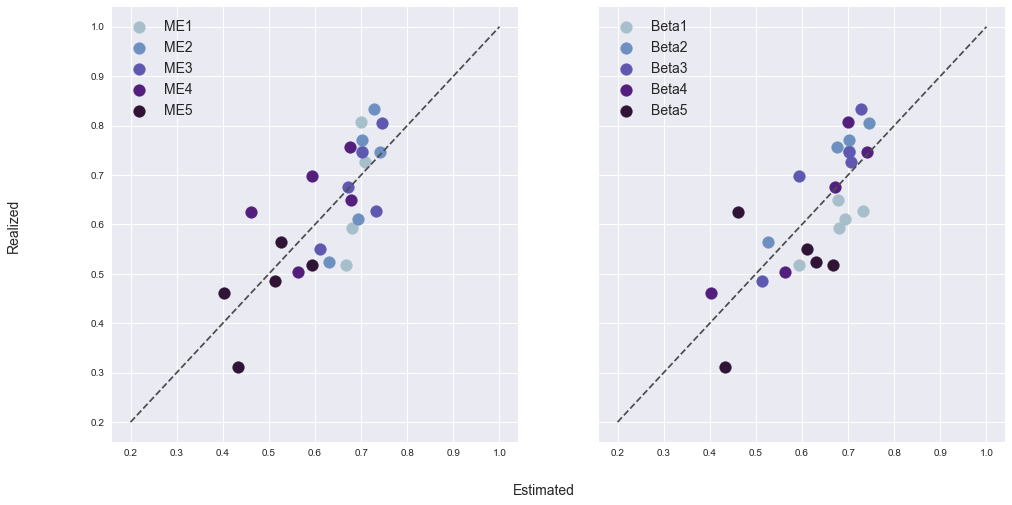

In [26]:
# Make the scatter plot 
fig, axes = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)
fig.text(0.04, 0.5, 'Realized', va='center', ha='center',rotation='vertical',fontsize = 14)
fig.text(0.5,0.04, 'Estimated', va='center', ha='center',rotation='horizontal',fontsize = 14)
colormap = plt.cm.get_cmap('twilight') 
colors = [colormap(i) for i in np.linspace(0.1, 0.5,5)]
axes[0].plot([0.2, 1], [0.2, 1], ls="--", c=".3")
for i in range(0,5):
    axes[0].scatter(Estimated[i*5:(i+1)*5],Realized[i*5:(i+1)*5],c=colors[i],label = 'ME'+str(i+1), s=140)
axes[0].legend(fontsize = 14)
axes[1].plot([0.2, 1], [0.2, 1], ls="--", c=".3")
for i in range(0,5):
    axes[1].scatter(Estimated[i::5],Realized[i::5],c=colors[i],label = 'BM'+str(i+1), s=140)
axes[1].legend(fontsize = 14)
plt.plot()
plt.savefig('Scatter_mebetaCAPM')
plt.show()


### Return predictability test
1. Default spread
2. Short rate

In [144]:
to_predict= dfFactor[['Mkt-RF']].rolling(12).sum().shift(-12)

0 Spread
1 RF


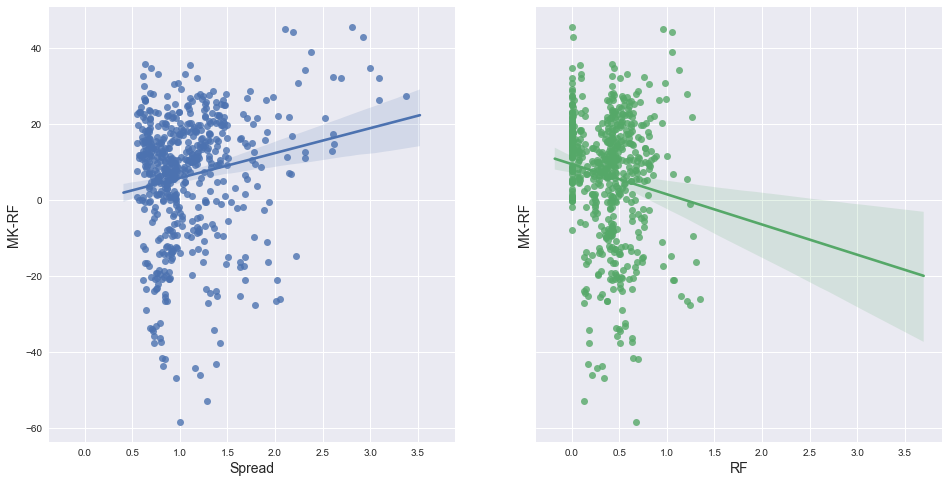

In [145]:
# Make the scatter plot 
import seaborn as sns
fig, axes = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)
colormap = plt.cm.get_cmap('twilight') 
colors = [colormap(i) for i in np.linspace(0.3, 0.5,5)]
# axes[0].plot([0.2, 1], [0.2, 1], ls="--", c=".3")
for i, k in enumerate(dfFactor[['Spread','RF']].columns):
    print(i,k)
    sns.regplot(dfFactor[[k]],to_predict['Mkt-RF'],ax= axes[i])
    axes[i].set_xlabel(k, fontsize = 14)
    axes[i].set_ylabel('MK-RF', fontsize = 14)
# plt.plot()
plt.savefig('Return_predictability')
plt.show()


In [150]:
# Output the regression test result in latex
beta_matrix = pd.DataFrame()
for i in range(len(dfFactor[['Spread','RF']].columns)):
    y = to_predict[:-12]
    X = sm.add_constant(dfFactor[['Spread','RF']].iloc[:-12,i])
    model = sm.OLS(y, X)
    results = model.fit()
    beta_i = pd.DataFrame(results.params[1:]).T
    beta_i= beta_i.rename(index= {0:'coef'})
    beta_matrix= pd.concat([beta_matrix, beta_i])
    t_i = pd.DataFrame(results.tvalues[1:]).T
    t_i= t_i.rename(index= {0:'t'})
    beta_matrix= pd.concat([beta_matrix, t_i])    
print(beta_matrix.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &    RF &  Spread \\
\midrule
coef &   NaN &    6.55 \\
t    &   NaN &    4.32 \\
coef & -7.96 &     NaN \\
t    & -3.27 &     NaN \\
\bottomrule
\end{tabular}



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
